# ANALISIS DE PRODUCCIÓN EN POZOS NO CONVENCIONALES

**Importación de librerias**

In [1]:
import pandas as pd
import numpy as np
import statistics as stat
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno

## 👓 META DATA


Para este analisis usaremos los datos de producción de pozos no convencionales en diversos yacimientos de Argentina contenida en el sitio web de la Secretaria de Energia. 

In [2]:
# Obtenemos la URL de la API
url = "http://datos.energia.gob.ar/api/action/datastore_search"

# Obtenemos los Parámetros de la solicitud de la API, especificamente para los datos de pozos no convencionales
params = {"resource_id": "b5b58cdc-9e07-41f9-b392-fb9ec68b0725"}

import requests

# Obtenemos datos en formato JSON
response = requests.get(url, params=params)

data = response.json()

# Obtenemos el total de los registros 
total_records = data["result"]["total"]
params["limit"] = total_records
response = requests.get(url, params=params)

data = response.json()

# Convertimos los datos a un dataframe
dfP = pd.DataFrame.from_records(data["result"]["records"])
dfP.head()

,prod_agua,empresa,sub_tipo_recurso,coordenaday,iny_otro,idareayacimiento,tef,tipopozo,iny_agua,areapermisoconcesion,...,iny_gas,cuenca,vida_util,profundidad,idempresa,clasificacion,formprod,idusuario,fecha_data,proyecto
0,0.00,YSUR ENERGÍA ARGENTINA S.R.L.,TIGHT,-39.030246,0,Z155,31.0,Gasífero,0.0,ESTACION FERNANDEZ ORO,...,0.0,NEUQUINA,NaN,3949.0,YSUR,EXPLOTACION,LAJA,444,2017-01-31T00:00:00,GAS PLUS
1,11.50,YSUR ENERGÍA ARGENTINA S.R.L.,TIGHT,-38.867937,0,GUA,31.0,Gasífero,0.0,AL NORTE DE LA DORSAL,...,0.0,NEUQUINA,NaN,3375.0,YSUR,EXPLOTACION,PREC,5,2015-01-31T00:00:00,GAS PLUS
2,54.80,YSUR ENERGÍA ARGENTINA S.R.L.,TIGHT,-39.027375,0,ANCS,31.0,Gasífero,0.0,ANTICLINAL CAMPAMENTO,...,0.0,NEUQUINA,NaN,3915.0,YSUR,EXPLOTACION,PREC,444,2018-01-31T00:00:00,GAS PLUS
3,16.68,YSUR ENERGÍA ARGENTINA S.R.L.,TIGHT,-39.024859,0,ANCS,31.0,Gasífero,0.0,ANTICLINAL CAMPAMENTO,...,0.0,NEUQUINA,NaN,2338.4,YSUR,EXPLOTACION,PREC,444,2017-01-31T00:00:00,GAS PLUS
4,9.88,YSUR ENERGÍA ARGENTINA S.R.L.,TIGHT,-39.085068,0,RQC,31.0,Gasífero,0.0,AL SUR DE LA DORSAL,...,0.0,NEUQUINA,NaN,2638.0,YSUR,EXPLOTACION,PREC,5,2015-01-31T00:00:00,GAS PLUS


Adicionalmente obtendremos los datos de fracturas de estos pozos y procederemos a a unir ambos conjuntos de datos para crear un dataframe general.

In [3]:
# Obtenemos la URL de la API
url = "http://datos.energia.gob.ar/api/action/datastore_search"

# Obtenemos los Parámetros de la solicitud de la API:
params = {"resource_id": "2280ad92-6ed3-403e-a095-50139863ab0d"}

import requests
response = requests.get(url, params=params)

# Obtención de los datos en formato JSON
data = response.json()

total_records = data["result"]["total"]
params["limit"] = total_records
response = requests.get(url, params=params)

data = response.json()

DS_OG = pd.DataFrame.from_records(data["result"]["records"])

# Observamos las primeras filas de los datos de diseño de fractura
DS_OG.head()

,fecha_inicio_fractura,mes_carga,anio,longitud_rama_horizontal_m,presion_maxima_psi,co2_inyectado_m3,cantidad_fracturas,areapermisoconcesion,anio_ff,idpozo,...,fecha_fin_fractura,mes,cuenca,mes_if,anio_if,anio_carga,empresa_informante,fecha_data,formacion_productiva,yacimiento
0,2019-04-20T00:00:00,6,2019,0.0,10190.0,0.0,3,AGUA DEL CAJON,2019,159910,...,2019-04-30T00:00:00,4,NEUQUINA,4,2019,2019,CAPEX S.A.,2019-06-14T17:13:03,los molles,AGUA DEL CAJON
1,2018-11-02T00:00:00,6,2018,0.0,9250.0,0.0,1,AGUA DEL CAJON,2018,159910,...,2018-11-03T00:00:00,11,NEUQUINA,11,2018,2019,CAPEX S.A.,2019-06-14T17:14:19,los molles,AGUA DEL CAJON
2,2017-11-19T00:00:00,6,2017,1437.3,15000.0,0.0,18,AGUADA DE LA ARENA,2017,159219,...,2017-12-14T00:00:00,11,NEUQUINA,11,2017,2019,YPF S.A.,2019-06-27T13:46:21,vaca muerta,AGUADA DE LA ARENA
3,2017-11-21T00:00:00,6,2017,1518.3,11348.0,0.0,19,AGUADA DE LA ARENA,2017,159220,...,2017-12-15T00:00:00,11,NEUQUINA,11,2017,2019,YPF S.A.,2019-06-27T13:46:21,vaca muerta,AGUADA DE LA ARENA
4,2017-11-18T00:00:00,6,2017,1482.3,11076.0,0.0,19,AGUADA DE LA ARENA,2017,159221,...,2017-12-15T00:00:00,11,NEUQUINA,11,2017,2019,YPF S.A.,2019-06-27T13:46:21,vaca muerta,AGUADA DE LA ARENA


In [4]:
#Renombraremos la columna de longitud de rama horizontal para simplicar 
DS_OG.rename(columns={'longitud_rama_horizontal_m':'LRH'},inplace=True)

Procedemos a crear nuevas variables de uso comun en la industria para facilitar el analisis. Estas seran: longitud_etapa, intensidad_fluido e intensidad_arena.

In [5]:
DS_OG['longitud_etapa'] = DS_OG['LRH']/DS_OG['cantidad_fracturas']
DS_OG['intensidad_fluido'] =((DS_OG['agua_inyectada_m3']*6.29)/DS_OG['cantidad_fracturas'])/(DS_OG['longitud_etapa']*3.2808)
DS_OG['intensidad_arena'] =(((DS_OG['arena_bombeada_nacional_tn']+DS_OG['arena_bombeada_importada_tn'])*2204.6226)/DS_OG['cantidad_fracturas'])/(DS_OG['longitud_etapa']*3.2808)

Debido a que nuestro analisis se basara en los pozos PETROLIFEROS, ya que en estos la rentabilidad es mayor que en los pozos de gas, y en donde el recurso es SHALE, procedemos a depurar nuestro dataframe de producción quedandonos solo con los pozos que son petrolofieros y que donde el recurso es shale.

In [6]:
dfP.drop(dfP[dfP['tipopozo']!= "Petrolífero"].index, inplace=True)
dfP.drop(dfP[dfP['sub_tipo_recurso']!= "SHALE"].index, inplace=True)
dfP.shape

(86412, 40)

Como mencionamos anteriormente, procederemos a unir ambos datasets usando la función .merge. Como en ambas conjuntos de datos existen varias columnas que son comunes, primero las identificaremos con un sufijo (_DS_OG) y luego procederemos a eliminarlas. Calcularemos previamente la producción acumulada de petróleo, gas y agua para que ya nos queden incluidas en el dataset. 

In [7]:
# Transformamos fecha_data en formato fecha
dfP['fecha_data'] = pd.to_datetime(dfP['fecha_data'])

dfP = dfP.sort_values(by= ['sigla', 'fecha_data'])

# Agrupamos los registros por pozo y sumamos la producción de petróleo acumulada
dfP['prod_pet_acum'] = dfP.groupby('sigla')['prod_pet'].cumsum()

# Agrupamos los registros por pozo y sumamos la producción de gas acumulada
dfP['prod_gas_acum'] = dfP.groupby('sigla')['prod_gas'].cumsum()

# Agrupamos los registros por pozo y sumamos la producción de agua acumulada
dfP['prod_agua_acum'] = dfP.groupby('sigla')['prod_agua'].cumsum()

Crearemos ademas una variable llamada "meses_produccion" que nos permitira luego filtrar la producción por el tiempo que ha durado la misma.

In [8]:
dfP['meses_produccion'] = ((dfP['fecha_data'] - dfP.groupby('sigla')['fecha_data'].transform('min')) / np.timedelta64(1, 'M')).astype(int) + 1

Una vez realizado esto, porcedemos a hacer el merge de ambos datasets.

In [9]:
df = pd.merge(dfP, DS_OG, on='idpozo', how='inner', suffixes=('', '_DS_OG'))
df = df.filter(regex='^(?!.*DS_OG).*')

Tambien eliminaremos algunas variables que no nos dan información relevante para nuestro analisis.

In [10]:
df=df.drop(['rectificado','habilitado','observaciones','vida_util','idusuario','mes_carga','anio_carga'], axis=1)
df.shape

(72668, 63)

Finalmente observemos algunos datos de nuestro dataset integrando datos de producción y fractura y con el cual realizaremos nuestro analisis.

In [11]:
df.head()

,prod_agua,empresa,sub_tipo_recurso,coordenaday,iny_otro,idareayacimiento,tef,tipopozo,iny_agua,areapermisoconcesion,...,tipo_reservorio,fecha_fin_fractura,mes_if,anio_if,empresa_informante,formacion_productiva,yacimiento,longitud_etapa,intensidad_fluido,intensidad_arena
0,1773.966,AMERICAS PETROGAS ARGENTINA S.A.,SHALE,-37.479924,0,Y065,9.00000,Petrolífero,0.0,LOS TOLDOS II ESTE,...,NO CONVENCIONAL,2016-12-23T00:00:00,12,2016,TECPETROL S.A.,vaca muerta,LOS TOLDOS ESTE,75.0,26.306623,1871.330898
1,4055.282,AMERICAS PETROGAS ARGENTINA S.A.,SHALE,-37.479924,0,Y065,28.00000,Petrolífero,0.0,LOS TOLDOS II ESTE,...,NO CONVENCIONAL,2016-12-23T00:00:00,12,2016,TECPETROL S.A.,vaca muerta,LOS TOLDOS ESTE,75.0,26.306623,1871.330898
2,2844.543,AMERICAS PETROGAS ARGENTINA S.A.,SHALE,-37.479924,0,Y065,31.00000,Petrolífero,0.0,LOS TOLDOS II ESTE,...,NO CONVENCIONAL,2016-12-23T00:00:00,12,2016,TECPETROL S.A.,vaca muerta,LOS TOLDOS ESTE,75.0,26.306623,1871.330898
3,1939.890,AMERICAS PETROGAS ARGENTINA S.A.,SHALE,-37.479924,0,Y065,29.20833,Petrolífero,0.0,LOS TOLDOS II ESTE,...,NO CONVENCIONAL,2016-12-23T00:00:00,12,2016,TECPETROL S.A.,vaca muerta,LOS TOLDOS ESTE,75.0,26.306623,1871.330898
4,1504.200,AMERICAS PETROGAS ARGENTINA S.A.,SHALE,-37.479924,0,Y065,31.00000,Petrolífero,0.0,LOS TOLDOS II ESTE,...,NO CONVENCIONAL,2016-12-23T00:00:00,12,2016,TECPETROL S.A.,vaca muerta,LOS TOLDOS ESTE,75.0,26.306623,1871.330898


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72668 entries, 0 to 72667
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   prod_agua                     72668 non-null  float64       
 1   empresa                       72668 non-null  object        
 2   sub_tipo_recurso              72668 non-null  object        
 3   coordenaday                   72668 non-null  float64       
 4   iny_otro                      72668 non-null  int64         
 5   idareayacimiento              72668 non-null  object        
 6   tef                           72668 non-null  float64       
 7   tipopozo                      72668 non-null  object        
 8   iny_agua                      72668 non-null  float64       
 9   areapermisoconcesion          72668 non-null  object        
 10  iny_co2                       72668 non-null  int64         
 11  prod_gas                    

## 🔨 DATA WRANGLING

#### Identificación de datos nulos:

<AxesSubplot:>

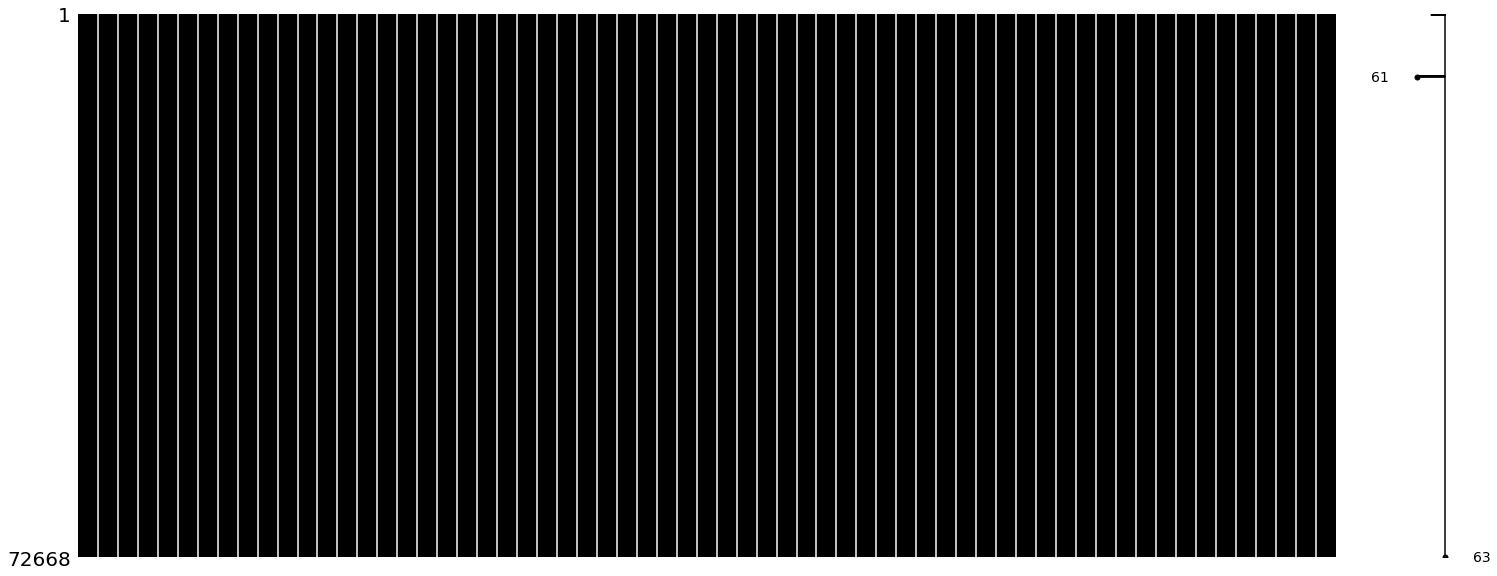

In [13]:
msno.matrix(df,color = (0,0,0))

No se obervan valores nulos en nuestro dataset. 

##### Identificación de valores duplicados en nuestro dataset:

In [14]:
df.duplicated().sum()

0

Como observamos no existen valores duplicados. 

Debido a que nalizaremos los pozos horizontales, procederemos a eliminar los registros correspondientes a los pozos verticales que son los que tienen una longitud de rama horizontal menor o igual a cero.

In [15]:
df.drop(df[df['LRH']<=0].index, inplace=True)

In [16]:
df.shape

(32498, 63)

In [18]:
df.to_excel('Pozos_NoConv.xlsx')